# Which climatology is the best for Panan-IS?

The climatology that is currently used to initialize our MOM6 and MOM5 simulations (WOA-based)is not appropriate for an Ice sheet coupled model. It is quite warm near the Ice shelves. Let's look at the different observational products for the Ice Shelf to see if we find one that makes a little more sense than the other. Let's also test an alternative extrapolation technique.




In [1]:
import cosima_cookbook as cc
from cosima_cookbook import distributed as ccd
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import glob,os
import cmocean.cm as cmocean

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [2]:
client = Client()

Importing data

In [3]:
lat_slice = slice(-90,-50)
Pauthenet_file = '/g/data/ik11/observations/Southern_Ocean_Climatology_PauthenetETAL2021/TS_Climato_Antarctic60S.nc'
WOA_file = '/g/data/ik11/inputs/access-om2/input_20201022/mom_01deg/ocean_temp_salt.res.nc'
Kaihes_file = '/g/data/ik11/users/wf4500/mom6-panAn-iceshelf-tools/initial-conditions/IC_Kaihe/Yamazaki_SO-Monthly-Climatology_v20240604.nc'


#importing data


#PAuthenet surface cell is centered at 10m
Pauthenet = xr.open_dataset(Pauthenet_file).sel(lat=lat_slice).isel(time=0)
loncorrected = Pauthenet.lon.where(Pauthenet.lon<=80,(Pauthenet.lon-360))
Pauthenet['lon'] = loncorrected
Pauthenet = Pauthenet.sortby('lon')
Pauthenet_editdepth = xr.concat((Pauthenet.depth.isel(depth=0)* 0,Pauthenet.depth),dim = 'depth').values
Pauthenet = xr.concat((Pauthenet.isel(depth=0),Pauthenet), dim = 'depth')
Pauthenet['depth'] = Pauthenet_editdepth

#Already
WOA = xr.open_dataset(WOA_file).sel(GRID_Y_T=lat_slice)

##Kaihe surface cell is centered at 5m
Kaihe = xr.open_dataset(Kaihes_file).sel(latitude=lat_slice).isel(month=0)
loncorrected = Kaihe.longitude.where(Kaihe.longitude<=80,(Kaihe.longitude-360))
Kaihe['longitude']=loncorrected
Kaihe = Kaihe.sortby('longitude')
Kaihe_editdepth = xr.concat((Kaihe.depth.isel(depth=0)* 0,Kaihe.depth),dim = 'depth').values
Kaihe = xr.concat((Kaihe.isel(depth=0),Kaihe), dim = 'depth')
Kaihe['depth'] = Kaihe_editdepth

Let's now interpolate the data to the OM2 grid

In [4]:
#Getting ocean mask 

ocean_mask_dir = '/g/data/ik11/inputs/mom6/panan/0025deg/20241214/ocean_mask.nc'
ocean_mask = xr.open_dataset(ocean_mask_dir)
ocean_mask_SO = ocean_mask.where(ocean_mask>0).isel(ny=slice(0,4000))

OM2_mask_path = '/g/data/ik11/inputs/access-om2/input_20201022/mom_01deg/ocean_mask.nc'

OM2_mask = xr.open_dataset(OM2_mask_path)

OM2_mask_for_interp = OM2_mask.sel(ny=slice(0,666)).rename({'ny':'GRID_Y_T','nx':'GRID_X_T'}).mask
OM2_mask_for_interp['GRID_Y_T'] = WOA.GRID_Y_T
OM2_mask_for_interp['GRID_X_T'] = WOA.GRID_X_T
OM2_mask_for_interp = OM2_mask_for_interp.where(OM2_mask_for_interp>0)

## Issue 1: Inverse Distance Weighted (IDW) interpolation

We will try to perform a barycentrin interpolation of WOA data to see if it fixes the leakage of Bellingshausen to the Weddell Sea

In [5]:
#first clearing out the bfilled contours
WOA_for_interp_temp_nan = WOA.temp * OM2_mask_for_interp

In [6]:
# #interpolating the data in a barycentric interpolation method
# WOA_for_interp_temp = WOA_for_interp_temp_nan.interpolate_na(dim='GRID_Y_T',limit=200, method = "linear").bfill('GRID_Y_T')


In [7]:
from scipy.interpolate import BarycentricInterpolator
from scipy.interpolate import RegularGridInterpolator
from scipy.interpolate import interp2d

IDW function definition

In [8]:

def simple_idw(x, y, z, xi, yi):
    dist = distance_matrix(x,y, xi,yi)

    # In IDW, weights are 1 / distance
    weights = 1.0 / dist

    # Make weights sum to one
    weights /= weights.sum(axis=0)

    # Multiply the weights for each interpolated point by all observed Z-values
    zi = np.dot(weights.T, z)
    return zi

def linear_rbf(x, y, z, xi, yi):
    dist = distance_matrix(x,y, xi,yi)

    # Mutual pariwise distances between observations
    internal_dist = distance_matrix(x,y, x,y)

    # Now solve for the weights such that mistfit at the observations is minimized
    weights = np.linalg.solve(internal_dist, z)

    # Multiply the weights for each interpolated point by the distances
    zi =  np.dot(dist.T, weights)
    return zi


def scipy_idw(x, y, z, xi, yi):
    interp = Rbf(x, y, z, function='linear')
    return interp(xi, yi)

def scipy_idw_function(x, y, z, xi, yi):
    interp = Rbf(x, y, z, function='thin_plate')
    return interp(xi, yi)

def distance_matrix(x0, y0, x1, y1):
    obs = np.vstack((x0, y0)).T
    interp = np.vstack((x1, y1)).T

    # Make a distance matrix between pairwise observations
    # Note: from <http://stackoverflow.com/questions/1871536>
    # (Yay for ufuncs!)
    d0 = np.subtract.outer(obs[:,0], interp[:,0])
    d1 = np.subtract.outer(obs[:,1], interp[:,1])

    return np.hypot(d0, d1)


def plot(x,y,z,grid):
    plt.imshow(grid, extent=(x.min(), x.max(), y.max(), y.min()))
    #plt.pcolormesh(xi,yi,grid)
    plt.scatter(x,y,c=z,s=10, edgecolor = 'black')
    plt.colorbar()
    # plt.xlim(-1.2,0.2)
    # plt.ylim(-1.2,0.2)

def plot_noline(x,y,z,grid):
    #plt.imshow(grid, extent=(x.min(), x.max(), y.max(), y.min()))
    plt.pcolormesh(xi,yi,grid)
    plt.scatter(x,y,c=z,s=10)
    plt.colorbar()
    # plt.xlim(-1.2,0.2)
    # plt.ylim(-1.2,0.2)


IDW example 1 

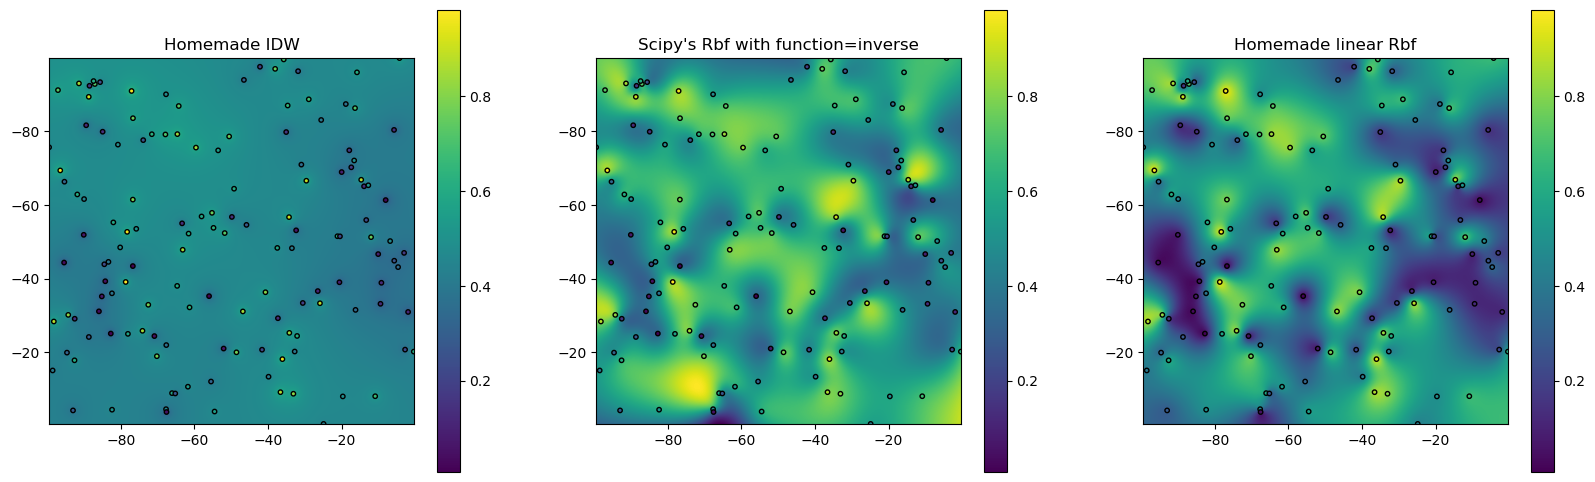

CPU times: user 25.4 s, sys: 7.95 s, total: 33.4 s
Wall time: 25.5 s


In [9]:
%%time
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import Rbf


n = 140
nx, ny = 3600, 666
x, y, z = map(np.random.random, [n, n, n])
x = -x*100
y = -y*100
xi = np.linspace(x.min(), x.max(), nx)
yi = np.linspace(y.min(), y.max(), ny)
xi, yi = np.meshgrid(xi, yi)
xi, yi = xi.flatten(), yi.flatten()

# Calculate IDW
grid1 = simple_idw(x,y,z,xi,yi)
grid1 = grid1.reshape((ny, nx))

# Calculate scipy's RBF
grid2 = scipy_idw_function(x,y,z,xi,yi)
grid2 = grid2.reshape((ny, nx))

grid3 = linear_rbf(x,y,z,xi,yi)
grid3 = grid3.reshape((ny, nx))

plt.figure(figsize = (20,6))
plt.subplot(1,3,1)
plot(x,y,z,grid1)
plt.title('Homemade IDW')

plt.subplot(1,3,2)
plot(x,y,z,grid2)
plt.title("Scipy's Rbf with function=inverse")

plt.subplot(1,3,3)
plot(x,y,z,grid3)
plt.title('Homemade linear Rbf')

plt.show()


Test 2, with a defined triangular shape with randomly generated data

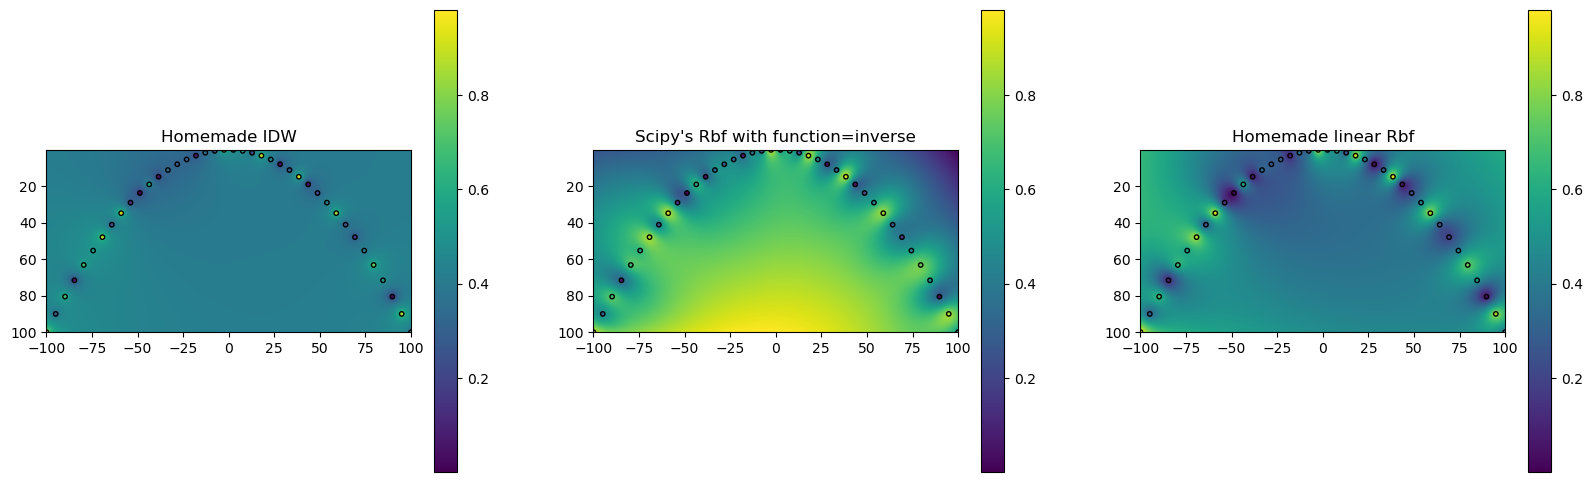

In [34]:
def quadratic(x):
    return x**2

n = 40
nx, ny = 3600, 666
# x, y, z = map(np.random.random, [n, n, n])
x = np.linspace(-100,100,n)
#y = (np.append(np.linspace(-100,-50,int(n/2)),np.linspace(-50,-100,int(n/2))))
y = quadratic(x)/100
z = np.random.random(np.shape(x))
xi = np.linspace(x.min(), x.max(), nx)
yi = np.linspace(y.min(), y.max(), ny)
xi, yi = np.meshgrid(xi, yi)
xi, yi = xi.flatten(), yi.flatten()

# Calculate IDW
grid1 = simple_idw(x,y,z,xi,yi)
grid1 = grid1.reshape((ny, nx))

# Calculate scipy's RBF
grid2 = scipy_idw_function(x,y,z,xi,yi)
grid2 = grid2.reshape((ny, nx))

grid3 = linear_rbf(x,y,z,xi,yi)
grid3 = grid3.reshape((ny, nx))

plt.figure(figsize = (20,6))
plt.subplot(1,3,1)
plot(x,y,z,grid1)
plt.title('Homemade IDW')

plt.subplot(1,3,2)
plot(x,y,z,grid2)
plt.title("Scipy's Rbf with function=inverse")

plt.subplot(1,3,3)
plot(x,y,z,grid3)
plt.title('Homemade linear Rbf')

plt.show()


## Applying IDW on the IC conditions

### Part 1 - extracting IC along the coast

To use the IDW interpolation, we will need to do a few things.


1- create a matrix of the coastal non-NaN valuest along the contour. We can use Claire's code for that

2-Then we can use the IDW to interpolate values to the southermost latitude with existing value on the grid

3 - finally, we can bfill using this new data

In [11]:
#Importing bathymetry
session = cc.database.create_session()
experiment = '01deg_jra55v13_ryf9091'

yt_ocean = cc.querying.getvar(experiment, 'yt_ocean', session, n=1)
yt_ocean = yt_ocean.sel(yt_ocean = lat_slice)[:-1]

xt_ocean = cc.querying.getvar(experiment, 'xt_ocean', session, n=1)

yu_ocean = cc.querying.getvar(experiment, 'yu_ocean', session, n=1)
yu_ocean = yu_ocean.sel(yu_ocean = lat_slice)

xu_ocean = cc.querying.getvar(experiment, 'xu_ocean', session, n=1)

if len(yt_ocean) != len(yu_ocean):
    print('help! y different size')

if yt_ocean.min('yt_ocean')> yu_ocean.min('yu_ocean'):
    print('help! wrong order')

if len(xt_ocean) != len(xu_ocean):
    print('help! x different size')

if xt_ocean.min('xt_ocean')> xu_ocean.min('xu_ocean'):
    print('help! x wrong order')


ht = cc.querying.getvar(experiment, 'ht', session, n=1).sel(yt_ocean = lat_slice)

contour_depth = 0 # metres

In [12]:
# we will need to fill the NaNs with a incredibly low negative value, sothe ocean point is always close to 0 than the land one
ht = ht.fillna(-99999).load()

In [13]:
grid_sel = 't'
x_var = xt_ocean
y_var = yt_ocean

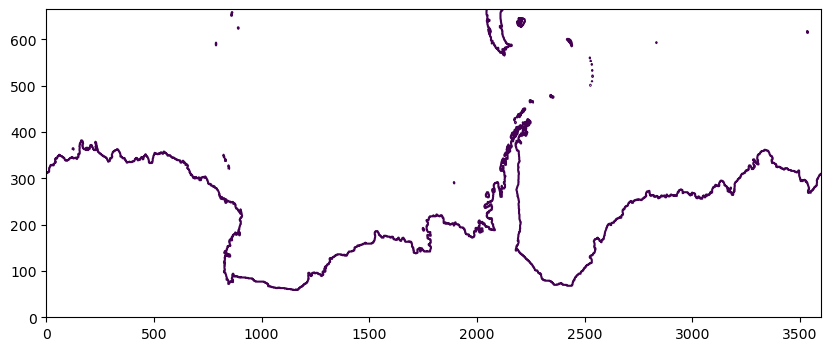

In [14]:
fig = plt.figure(figsize = (10, 4))
sc = plt.contour(ht, levels=[contour_depth])

path_vertices = (sc.get_paths()[0]).vertices
x_vertices = path_vertices[:, 0]
y_vertices = path_vertices[:, 1]

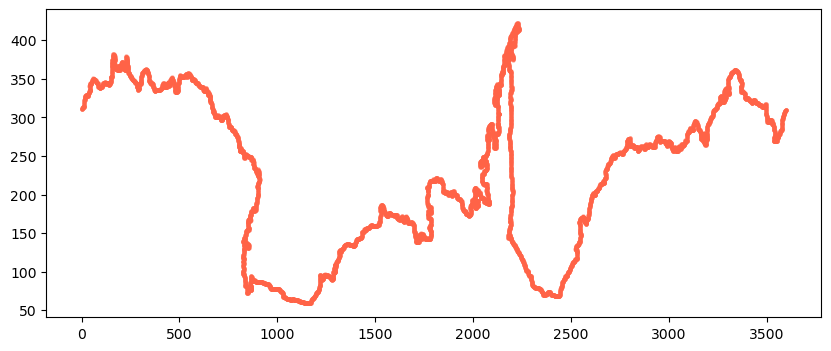

In [15]:
# For some reason we need a threshold of 1.01 here not just 1. Not sure why...
last_contour_index = np.where(np.abs(np.diff(x_vertices)) > 1.01)[0][0]

x_contour = x_vertices[:last_contour_index + 1]
y_contour = y_vertices[:last_contour_index + 1]

# Check desired contour looks right:
fig = plt.figure(figsize = (10, 4))
plt.scatter(x_contour, y_contour, s=5, alpha=0.5, color='tomato');

In [16]:
x_contour = np.round(x_contour).astype(int)
y_contour = np.round(y_contour).astype(int)

# check that the difference between coords of contour never increase by more than 1:
if np.max(np.abs(np.diff(x_contour))) != 1:
    print('help! x_contour increases by more than 1 between coords.')

if np.max(np.abs(np.diff(y_contour))) != 1:
    print('help! y_contour increases by more than 1 between coords.')

In [17]:
# Difference between two neighbouring indices
diff_x_contour = np.diff(x_contour)
diff_y_contour = np.diff(y_contour)

# Get a list with the indices of duplicates
diff_ind = []
for ii in range(len(diff_x_contour)):
    if (diff_x_contour[ii]==0) and (diff_y_contour[ii]==0):
        diff_ind.append(ii)

In [18]:
# Now remove the indices (start from the end so the indices don't shift)
for ii in range(len(diff_ind)):
    index = diff_ind[::-1][ii]
    x_contour = np.delete(x_contour, index)
    y_contour = np.delete(y_contour, index)

In [19]:
ht_contour = np.zeros(len(x_contour))

for ii in range(len(ht_contour)):
    ht_contour[ii] = ht[y_contour[ii], x_contour[ii]]

In [20]:
# Number of grid points on the contour
num_points = len(x_contour)
# start numbering from 1 not 0:
contour_mask_numbered = np.arange(1, len(x_contour)+1)

contour_mask = xr.zeros_like(ht)

for ii in range(num_points):
    contour_mask[y_contour[ii], x_contour[ii]] = contour_mask_numbered[ii]

In [21]:
%%time

mask_value = -1000
contour_mask_numbered = contour_mask

# fill in points to north of contour:
contour_masked_above = np.copy(contour_mask_numbered)
contour_masked_above[-1, 0] = mask_value

# from top left:
for ii in range(len(contour_mask.xt_ocean)-1):
    for jj in range(len(contour_mask.yt_ocean))[::-1][:-1]:
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj-1, ii] == 0:
                contour_masked_above[jj-1, ii] = mask_value
            if contour_masked_above[jj, ii+1] == 0:
                contour_masked_above[jj, ii+1] = mask_value

#from top right:
for ii in range(len(contour_mask.xt_ocean))[::-1][:-1]:
    for jj in range(len(contour_mask.yt_ocean))[::-1][:-1]:
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj-1, ii] == 0:
                contour_masked_above[jj-1, ii] = mask_value
            if contour_masked_above[jj, ii-1] == 0:
                contour_masked_above[jj, ii-1] = mask_value

# from bottom right:
for ii in range(len(contour_mask.xt_ocean))[::-1][:-1]:
    for jj in range(len(contour_mask.yt_ocean)-1):
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj+1, ii] == 0:
                contour_masked_above[jj+1, ii] = mask_value
            if contour_masked_above[jj, ii-1] == 0:
                contour_masked_above[jj, ii-1] = mask_value

#from bottom left:
for ii in range(len(contour_mask.xt_ocean)-1):
    for jj in range(len(contour_mask.yt_ocean)-1):
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj+1, ii] == 0:
                contour_masked_above[jj+1, ii] = mask_value
            if contour_masked_above[jj, ii+1] == 0:
                contour_masked_above[jj, ii+1] = mask_value

CPU times: user 6.26 s, sys: 60.3 ms, total: 6.32 s
Wall time: 6.26 s


In [22]:
%%time
mask_x_transport = np.zeros_like(contour_mask_numbered)
mask_y_transport = np.zeros_like(contour_mask_numbered)

mask_y_transport_numbered = np.zeros_like(contour_mask_numbered)
mask_x_transport_numbered = np.zeros_like(contour_mask_numbered)

# make halos:
shape = contour_masked_above.shape
contour_masked_above_halo = np.zeros((shape[0], shape[1]+2))
contour_masked_above_halo[:, 0] = contour_masked_above[:, -1]
contour_masked_above_halo[:, 1:-1] = contour_masked_above
contour_masked_above_halo[:, -1] = contour_masked_above[:, 0]

new_number_count = 1
for mask_loc in range(1, int(np.max(contour_mask_numbered))+1):
    index_i = np.where(contour_mask_numbered==mask_loc)[1]
    index_j = np.where(contour_mask_numbered==mask_loc)[0]
    # if point above is towards Antarctica and point below is away from Antarctica:
    # take transport grid point to north of t grid:
    if (contour_masked_above[index_j+1, index_i]==0) and (contour_masked_above[index_j-1, index_i]!=0):
        mask_y_transport[index_j, index_i] = -1
        # important to do 
        mask_y_transport_numbered[index_j, index_i] = new_number_count
        new_number_count += 1
    # if point below is towards Antarctica and point above is away from Antarctica:
    # take transport grid point to south of t grid:
    elif (contour_masked_above[index_j-1, index_i]==0) and (contour_masked_above[index_j+1, index_i]!=0):
        mask_y_transport[index_j-1, index_i] = 1
        mask_y_transport_numbered[index_j-1, index_i] = new_number_count
        new_number_count += 1
    # if point below and point above are BOTH towards Antarctica:
    # take transport grid point to south of t grid:
    elif (contour_masked_above[index_j-1, index_i]==0) and (contour_masked_above[index_j+1, index_i]==0):
        mask_y_transport[index_j-1, index_i] = 1
        mask_y_transport[index_j, index_i] = -1        
        mask_y_transport_numbered[index_j-1, index_i] = new_number_count
        mask_y_transport_numbered[index_j, index_i] = new_number_count+1
        new_number_count += 2
    # if point to right is towards Antarctica and point to left is away from Antarctica:
    # zonal indices increased by 1 due to halos
    # take transport grid point on right of t grid:
    if (contour_masked_above_halo[index_j, index_i+2]==0) and (contour_masked_above_halo[index_j, index_i]!=0):
        mask_x_transport[index_j, index_i] = -1
        mask_x_transport_numbered[index_j, index_i] = new_number_count
        new_number_count += 1
    # if point to left is towards Antarctica and point to right is away from Antarctica:
    # take transport grid point on left of t grid:
    elif (contour_masked_above_halo[index_j, index_i]==0) and (contour_masked_above_halo[index_j, index_i+2]!=0):
        mask_x_transport[index_j, index_i-1] = 1
        mask_x_transport_numbered[index_j, index_i-1] = new_number_count
        new_number_count += 1
    # if point to left and right BOTH toward Antarctica
    elif (contour_masked_above_halo[index_j, index_i]==0) and (contour_masked_above_halo[index_j, index_i+2]==0):
        mask_x_transport[index_j, index_i-1] = 1
        mask_x_transport[index_j, index_i] = -1        
        mask_x_transport_numbered[index_j, index_i-1] = new_number_count
        mask_x_transport_numbered[index_j, index_i] = new_number_count+1
        new_number_count += 2

CPU times: user 2min 8s, sys: 4.7 s, total: 2min 12s
Wall time: 1min 42s


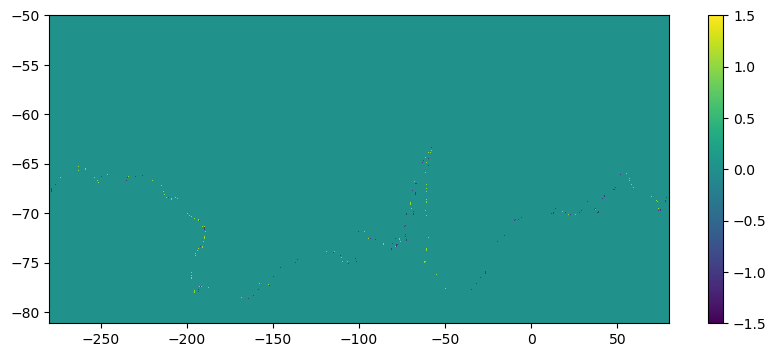

In [23]:
# Plot the mask for the x-transport:
plt.figure(1, figsize=(10, 4))

plt.pcolormesh(contour_mask.xt_ocean, contour_mask.yt_ocean, mask_x_transport,
               vmin=-1.5, vmax=1.5)
plt.colorbar();

In [24]:
mask_x_transport_numbered = mask_x_transport_numbered[:-1,:]
mask_y_transport_numbered = mask_y_transport_numbered[:-1,:]
mask_x_transport_numbered = xr.DataArray(mask_x_transport_numbered,
                                         coords = [yt_ocean, xu_ocean],
                                         dims = ['latitude', 'longitude'])
mask_y_transport_numbered = xr.DataArray(mask_y_transport_numbered,
                                         coords = [yu_ocean, xt_ocean],
                                         dims = ['latitude', 'longitude'])

In [25]:
# stack contour data into 1d:
mask_x_numbered_1d = mask_x_transport_numbered.stack(contour_index = ['latitude', 'longitude'])
mask_x_numbered_1d = mask_x_numbered_1d.where(mask_x_numbered_1d > 0, drop = True)

mask_y_numbered_1d = mask_y_transport_numbered.stack(contour_index = ['latitude', 'longitude'])
mask_y_numbered_1d = mask_y_numbered_1d.where(mask_y_numbered_1d > 0, drop = True)

contour_ordering = xr.concat((mask_x_numbered_1d, mask_y_numbered_1d), dim = 'contour_index')
contour_ordering = contour_ordering.sortby(contour_ordering)
contour_index_array = np.arange(1, len(contour_ordering)+1)

In [26]:
contour_ordering = xr.concat((mask_x_numbered_1d, mask_y_numbered_1d), dim = 'contour_index')
contour_ordering = contour_ordering.sortby(contour_ordering)

# get lat and lon along contour, useful for plotting later:
lat_along_contour = contour_ordering.latitude.copy()
lon_along_contour = contour_ordering.longitude.copy()

contour_index_array = np.arange(1, len(contour_ordering)+1)

# don't need the multi-index anymore, replace with contour count and save
lat_along_contour.coords['contour_index'] = contour_index_array
lon_along_contour.coords['contour_index'] = contour_index_array

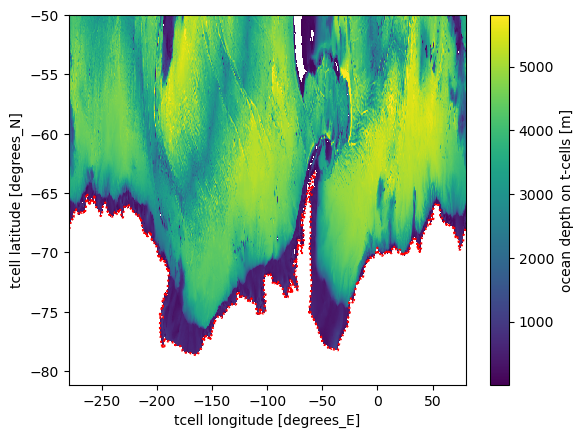

In [27]:
#sanity check
ht.where(ht>=0).plot()
plt.plot(lon_along_contour,lat_along_contour,color = 'red',linestyle = ':')

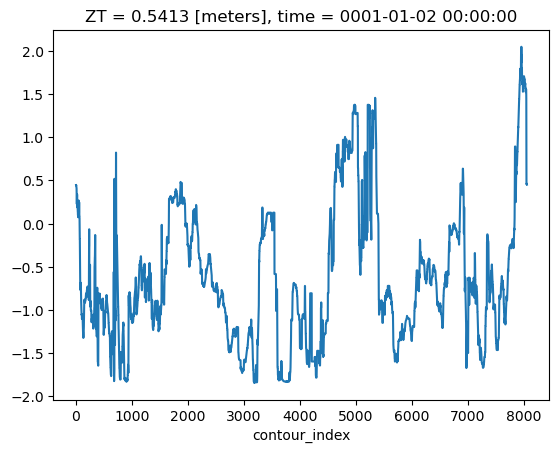

In [28]:
SST_alon_coast = WOA_for_interp_temp_nan.isel(time=0,ZT=0).sel(GRID_X_T = lon_along_contour, GRID_Y_T = lat_along_contour, method = 'nearest')
SST_alon_coast = SST_alon_coast.interpolate_na(dim='contour_index',method = 'nearest')
SST_alon_coast.plot()

(-79.0, -63.0)

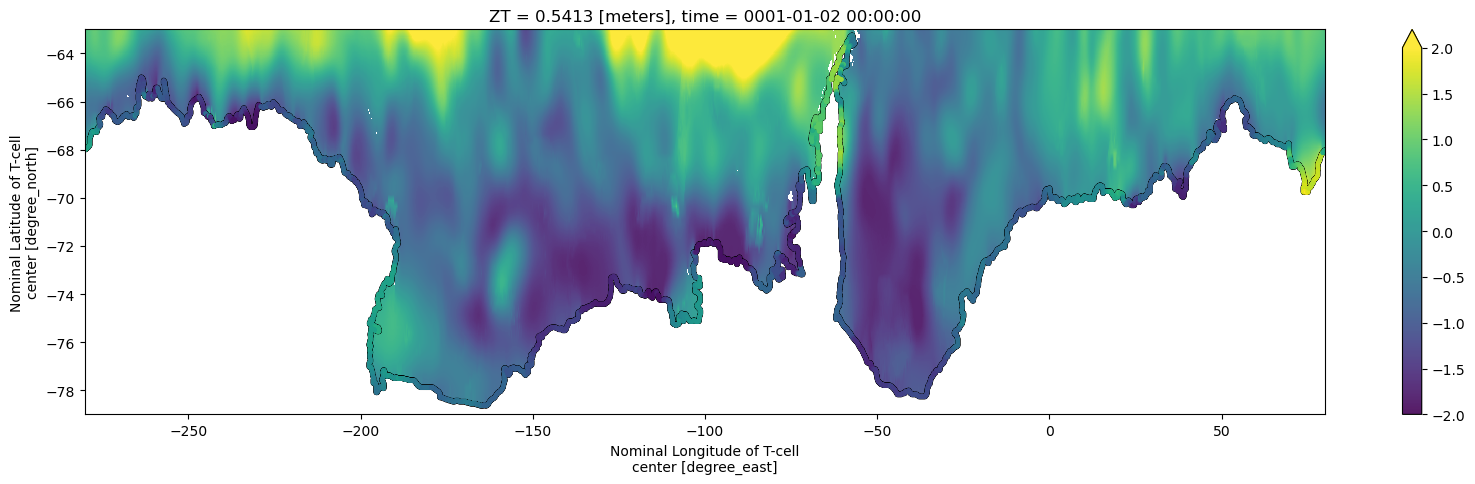

In [29]:
#sanity check 2
plt.figure(figsize = (20,5))
WOA_for_interp_temp_nan.isel(time=0,ZT=0).plot(cmap = 'viridis', vmin=-2,vmax =2,alpha=0.9)
plt.scatter(lon_along_contour,lat_along_contour,c=SST_alon_coast,s=8, vmin=-2,vmax =2,edgecolor = 'black')
plt.scatter(lon_along_contour,lat_along_contour,c=SST_alon_coast,s=5, vmin=-2,vmax =2)
plt.ylim(-79,-63)

### Part 2, running the IDW interpolant

creating xarray version of np functions used for IDW


**Attention** : This is a very memory-heavy cell 

In [30]:
%%time
lat_slice_interp = slice(-79,-63)
lat_distance_ratio_blowup = 2.5 # this a latitude streching approach that is used with the aim of making sure latitudinal propagaion is minimal
x = np.array(lon_along_contour).astype('float32')
y = np.array(lat_along_contour).astype('float32') * lat_distance_ratio_blowup
z = np.array(SST_alon_coast).astype('float32')

xi = np.array(WOA_for_interp_temp_nan.GRID_X_T).astype('float32')
yi = np.array(WOA_for_interp_temp_nan.GRID_Y_T.sel(GRID_Y_T=lat_slice_interp)).astype('float32') * lat_distance_ratio_blowup
xi, yi = np.meshgrid(xi, yi)
xi, yi = xi.flatten(), yi.flatten()

grid3 = linear_rbf(x,y,z,xi,yi)

nx = np.array(WOA_for_interp_temp_nan.GRID_X_T).shape[0]
ny = np.array(WOA_for_interp_temp_nan.GRID_Y_T.sel(GRID_Y_T=lat_slice_interp)).shape[0]
grid3 = grid3.reshape((ny, nx))

CPU times: user 2min 14s, sys: 47.7 s, total: 3min 2s
Wall time: 2min 15s


how does the IDW interpolate data looks like?

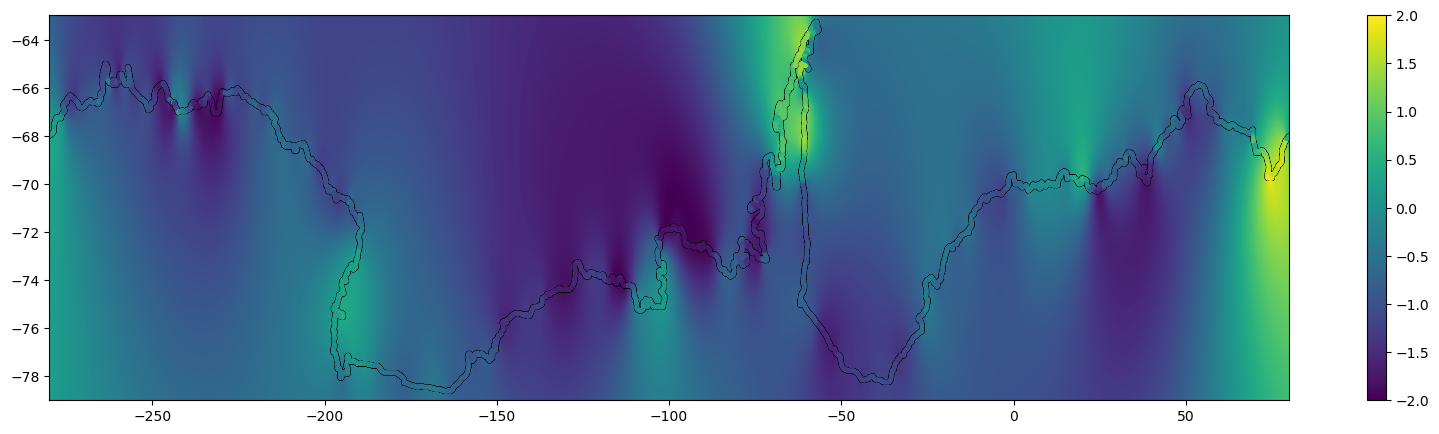

In [31]:
plt.figure(figsize = (20,5))
plt.pcolormesh(WOA_for_interp_temp_nan.GRID_X_T,\
               np.array(WOA_for_interp_temp_nan.GRID_Y_T.sel(GRID_Y_T=lat_slice_interp)),grid3)
plt.scatter(lon_along_contour,lat_along_contour,c=SST_alon_coast,s=9, vmin=-2,vmax =2,edgecolor = 'black')
plt.scatter(lon_along_contour,lat_along_contour,c=SST_alon_coast,s=5, vmin=-2,vmax =2)
plt.xlim(-280,80)
plt.colorbar()

In [32]:
#creating the xarray with the same dimensions as the original IC
WOA_IDW = WOA_for_interp_temp_nan.sel(GRID_Y_T=lat_slice_interp).isel(time=0,ZT=0)
WOA_IDW.values =  grid3

WOA_IDW_expanded = WOA_IDW.interp(GRID_Y_T = WOA_for_interp_temp_nan.GRID_Y_T).bfill('GRID_Y_T')
WOA_IDW_expanded_appeneded = WOA_for_interp_temp_nan.isel(time=0,ZT=0).fillna(-99999).ffill('GRID_Y_T')
WOA_IDW_expanded_appeneded = WOA_IDW_expanded_appeneded.where(WOA_IDW_expanded_appeneded>=-9999,WOA_IDW_expanded)

In [33]:
# import some useful packages
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from dask.distributed import Client
import cartopy.crs as ccrs
import cmocean.cm as cmo
import matplotlib.path as mpath


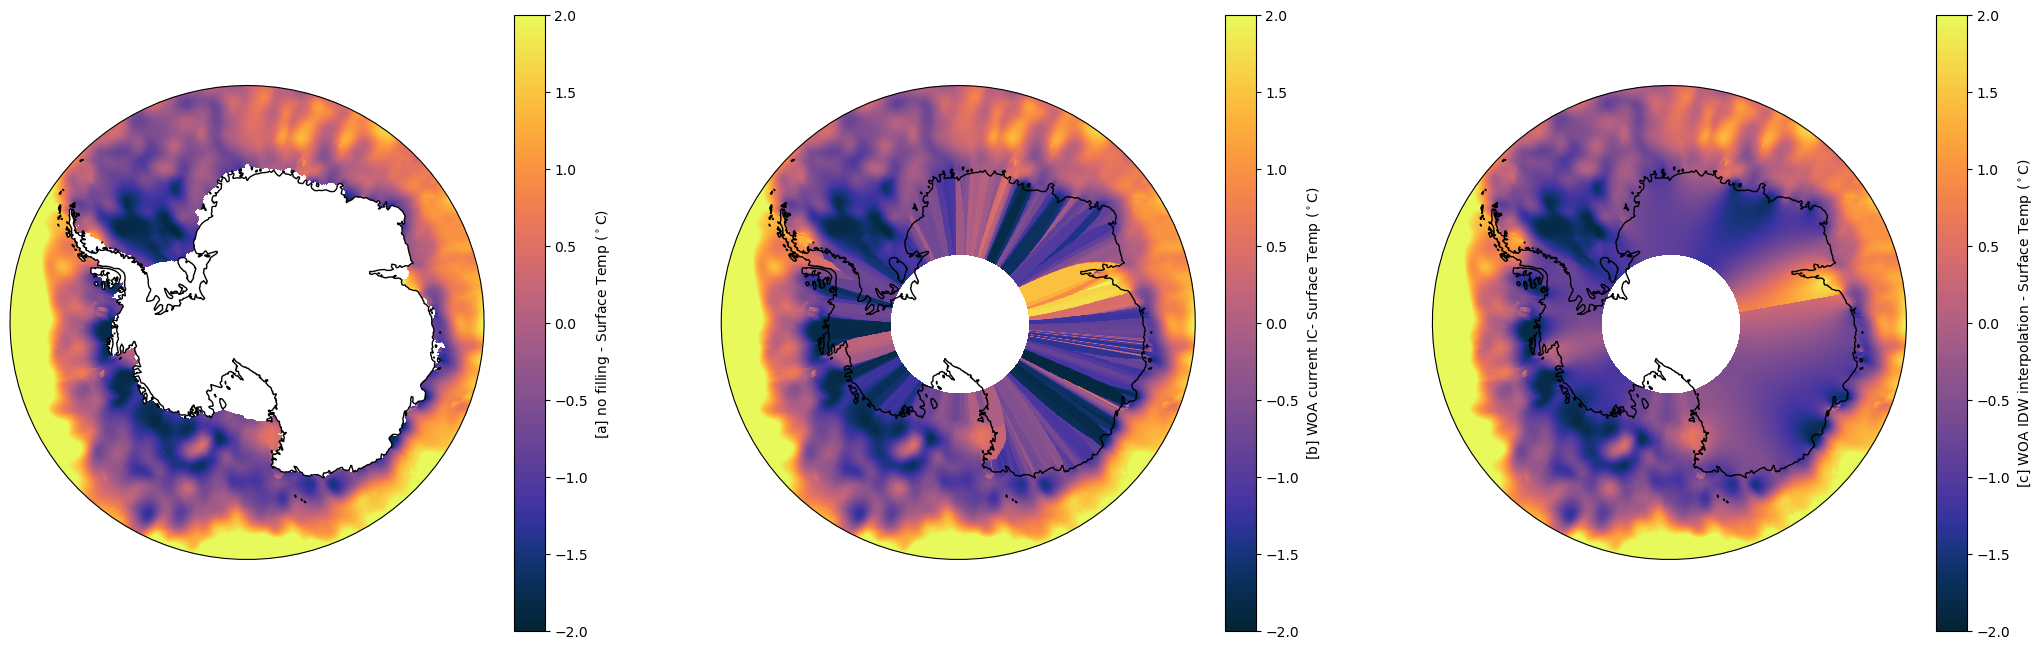

In [138]:
projection = ccrs.SouthPolarStereo()

fig = plt.figure(figsize=(26,8))
ax = fig.add_subplot(1,3,2,projection=projection)

ax.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree()) # plotting from COSIMA recipes cartopy tutorial
ax.coastlines(resolution="50m")



theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)


plt.pcolormesh(WOA.GRID_X_T,
               WOA.GRID_Y_T,
               WOA.temp.isel(ZT=0,time = 0),
               transform=ccrs.PlateCarree(), vmin = -2, vmax = 2, cmap = cmo.thermal)
plt.colorbar(label = '[b] WOA current IC- Surface Temp ($^\circ$C)')



ax222 = fig.add_subplot(1,3,3,projection=projection)
ax222.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree()) # plotting from COSIMA recipes cartopy tutorial
ax222.coastlines(resolution="50m")



theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax222.set_boundary(circle, transform=ax222.transAxes)


plt.pcolormesh(WOA_IDW_expanded_appeneded.GRID_X_T,
               WOA_IDW_expanded_appeneded.GRID_Y_T,
               WOA_IDW_expanded_appeneded,
               transform=ccrs.PlateCarree(), vmin = -2, vmax = 2, cmap =  cmo.thermal)
plt.colorbar(label = '[c] WOA IDW interpolation - Surface Temp ($^\circ$C)')


ax223 = fig.add_subplot(1,3,1,projection=projection)
ax223.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree()) # plotting from COSIMA recipes cartopy tutorial
ax223.coastlines(resolution="50m")



theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax223.set_boundary(circle, transform=ax223.transAxes)


plt.pcolormesh(WOA_for_interp_temp_nan.GRID_X_T,
               WOA_for_interp_temp_nan.GRID_Y_T,
               WOA_for_interp_temp_nan.isel(ZT=0,time = 0),
               transform=ccrs.PlateCarree(), vmin = -2, vmax = 2, cmap = cmo.thermal)
plt.colorbar(label = '[a] no filling - Surface Temp ($^\circ$C)')

It seems like it roughly happens, although a discontinuity happens close to Prydz bay. That happens in the previous conditions anyways. And it also could be corrected by using other observational producs

## Issue 2: Choice of initial conditions

We currently use WOA IC, which seems to be overall pretty warm in some regions, and can create a strong initial melting in the model (e.g., close to Prydz bay). Let's look how Pauthenet and Kaihe's IC look like - are they better and colder around the shelf?

### Part 1: Interpolating other data into OM2 grid

In [139]:
Pauthenet_OM2grid = Pauthenet.interp(lat = WOA.GRID_Y_T, lon = WOA.GRID_X_T,depth = WOA.ZT)

In [140]:
Kaihe_OM2grid = Kaihe.interp(latitude = WOA.GRID_Y_T, longitude = WOA.GRID_X_T,depth = WOA.ZT).bfill('GRID_Y_T')

Converting Pauthener In situ temperature to conservative temperature

In [141]:
import gsw

In [142]:
#first calcualting pressure
Pauthenet_P = - ( ((Pauthenet_OM2grid.Sal * 0)+1) * Pauthenet_OM2grid.ZT)
Pauthenet_P = gsw.p_from_z(-10,Pauthenet_OM2grid.GRID_Y_T)


#standardize size input vars
Pauthenet_P = ((Pauthenet_OM2grid.Sal * 0)+1) * Pauthenet_P
Pauthenet_lon = ((Pauthenet_OM2grid.Sal * 0)+1) * Pauthenet_OM2grid.lon
Pauthenet_lat = ((Pauthenet_OM2grid.Sal * 0)+1) * Pauthenet_OM2grid.lat

#calculating absolute salinity
Pauthenet_OM2grid_AS = gsw.SA_from_SP(Pauthenet_OM2grid.Sal,Pauthenet_P,Pauthenet_lon,Pauthenet_lat)

#calcualting conservative temperature
Pauthenet_OM2grid_CT = gsw.CT_from_t(Pauthenet_OM2grid_AS,Pauthenet_OM2grid.Temp,Pauthenet_P).bfill('GRID_Y_T')

Comparisson with OM2 current initial conditions

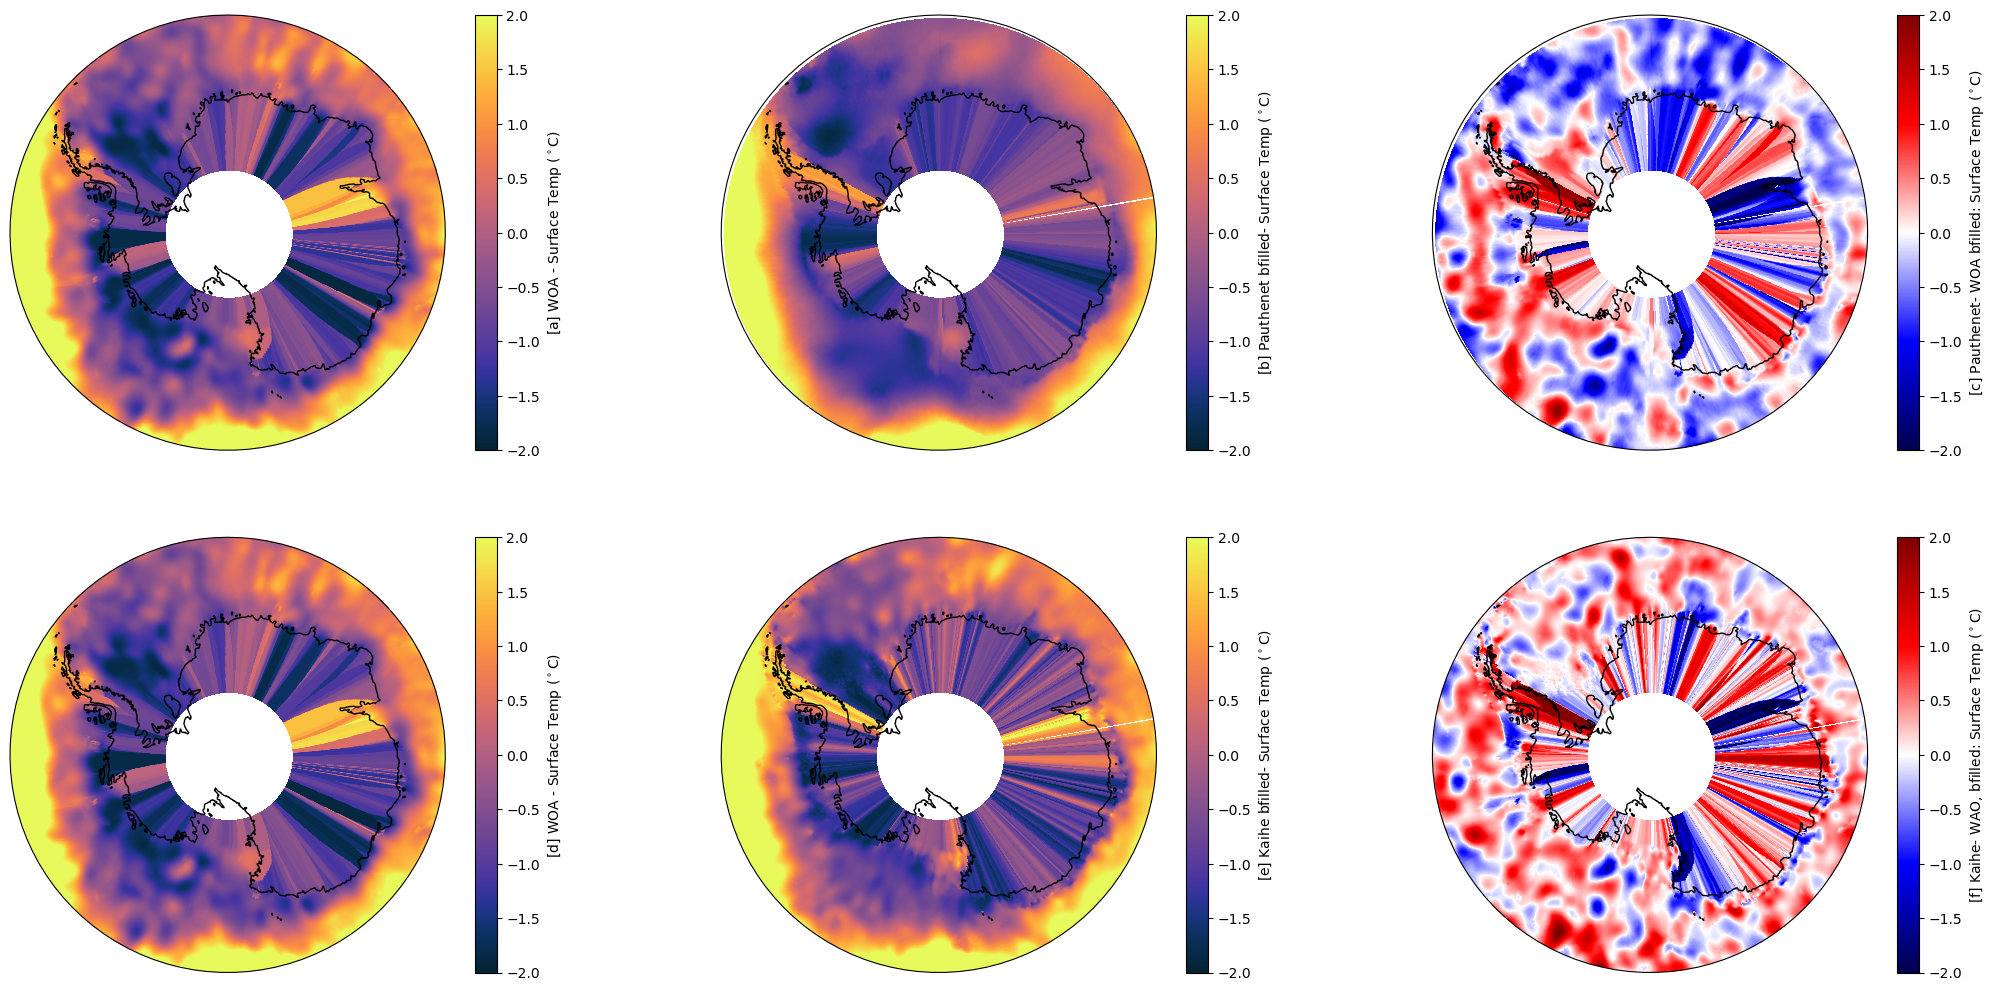

In [154]:
projection = ccrs.SouthPolarStereo()

fig = plt.figure(figsize=(26,26))
ax = fig.add_subplot(4,3,1,projection=projection)

ax.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree()) # plotting from COSIMA recipes cartopy tutorial
ax.coastlines(resolution="50m")



theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)


plt.pcolormesh(WOA.GRID_X_T,
               WOA.GRID_Y_T,
               WOA.temp.isel(ZT=0,time = 0),
               transform=ccrs.PlateCarree(), vmin = -2, vmax = 2, cmap = cmo.thermal)
plt.colorbar(label = '[a] WOA - Surface Temp ($^\circ$C)')



ax222 = fig.add_subplot(4,3,2,projection=projection)
ax222.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree()) # plotting from COSIMA recipes cartopy tutorial
ax222.coastlines(resolution="50m")



theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax222.set_boundary(circle, transform=ax222.transAxes)


plt.pcolormesh(Pauthenet_OM2grid_CT.GRID_X_T,
               Pauthenet_OM2grid_CT.GRID_Y_T,
               Pauthenet_OM2grid_CT.T.isel(ZT=0),
               transform=ccrs.PlateCarree(), vmin = -2, vmax = 2, cmap = cmo.thermal)
plt.colorbar(label = '[b] Pauthenet bfilled- Surface Temp ($^\circ$C)')



ax223 = fig.add_subplot(4,3,3,projection=projection)
ax223.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree()) # plotting from COSIMA recipes cartopy tutorial
ax223.coastlines(resolution="50m")




theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax223.set_boundary(circle, transform=ax223.transAxes)


plt.pcolormesh(Pauthenet_OM2grid_CT.GRID_X_T,
               Pauthenet_OM2grid_CT.GRID_Y_T,
               Pauthenet_OM2grid_CT.T.isel(ZT=0) - WOA.temp.isel(ZT=0,time = 0),
               transform=ccrs.PlateCarree(), vmin = -2, vmax = 2, cmap = 'seismic')
plt.colorbar(label = '[c] Pauthenet- WOA bfilled: Surface Temp ($^\circ$C)')




axl221= fig.add_subplot(4,3,4,projection=projection)

axl221.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree()) # plotting from COSIMA recipes cartopy tutorial
axl221.coastlines(resolution="50m")



theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
axl221.set_boundary(circle, transform=axl221.transAxes)


plt.pcolormesh(WOA.GRID_X_T,
               WOA.GRID_Y_T,
               WOA.temp.isel(ZT=0,time = 0),
               transform=ccrs.PlateCarree(), vmin = -2, vmax = 2, cmap = cmo.thermal)
plt.colorbar(label = '[d] WOA - Surface Temp ($^\circ$C)')



axl222= fig.add_subplot(4,3,5,projection=projection)
axl222.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree()) # plotting from COSIMA recipes cartopy tutorial
axl222.coastlines(resolution="50m")



theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
axl222.set_boundary(circle, transform=axl222.transAxes)


plt.pcolormesh(Kaihe_OM2grid.GRID_X_T,
               Kaihe_OM2grid.GRID_Y_T,
               Kaihe_OM2grid.temp.isel(ZT=0),
               transform=ccrs.PlateCarree(), vmin = -2, vmax = 2, cmap = cmo.thermal)
plt.colorbar(label = '[e] Kaihe bfilled- Surface Temp ($^\circ$C)')




axl223= fig.add_subplot(4,3,6,projection=projection)

axl223.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree()) # plotting from COSIMA recipes cartopy tutorial
axl223.coastlines(resolution="50m")



theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
axl223.set_boundary(circle, transform=axl223.transAxes)

plt.pcolormesh(Kaihe_OM2grid.GRID_X_T,
               Kaihe_OM2grid.GRID_Y_T,
               Kaihe_OM2grid.temp.isel(ZT=0) - WOA.temp.isel(ZT=0,time = 0),
               transform=ccrs.PlateCarree(), vmin = -2, vmax = 2, cmap = 'seismic')
plt.colorbar(label = '[f] Kaihe- WAO, bfilled: Surface Temp ($^\circ$C)')


Let's apply the IDW in Kaihe's and Pauthenet's data to see how these plots look like

#### Pauthenet's

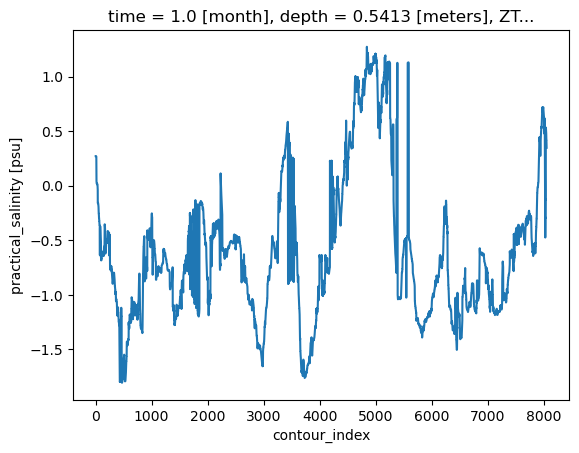

In [197]:
Pauthenet_SST_alon_coast = Pauthenet_OM2grid_CT.isel(ZT=0).sel(GRID_X_T = lon_along_contour, GRID_Y_T = lat_along_contour, method = 'nearest')
Pauthenet_SST_alon_coast = Pauthenet_SST_alon_coast.interpolate_na(dim='contour_index',method = 'nearest').bfill('contour_index')
Pauthenet_SST_alon_coast.plot()

In [254]:
%%time
lat_slice_interp = slice(-79,-63)
lat_distance_ratio_blowup = 4.5 # this a latitude streching approach that is used with the aim of making sure latitudinal propagaion is minimal
x = np.array(lon_along_contour).astype('float32')
y = np.array(lat_along_contour).astype('float32') * lat_distance_ratio_blowup
z = np.array(Pauthenet_SST_alon_coast).astype('float32')

xi = np.array(Pauthenet_OM2grid_CT.GRID_X_T).astype('float32')
yi = np.array(Pauthenet_OM2grid_CT.GRID_Y_T.sel(GRID_Y_T=lat_slice_interp)).astype('float32') * lat_distance_ratio_blowup
xi, yi = np.meshgrid(xi, yi)
xi, yi = xi.flatten(), yi.flatten()

grid3 = linear_rbf(x,y,z,xi,yi)

nx = np.array(Pauthenet_OM2grid_CT.GRID_X_T).shape[0]
ny = np.array(Pauthenet_OM2grid_CT.GRID_Y_T.sel(GRID_Y_T=lat_slice_interp)).shape[0]
grid3 = grid3.reshape((ny, nx))

CPU times: user 2min 43s, sys: 1min 6s, total: 3min 49s
Wall time: 2min 28s


In [255]:
#creating the xarray with the same dimensions as the original IC
Pauthenet_IDW = Pauthenet_OM2grid.Temp.sel(GRID_Y_T=lat_slice_interp).isel(ZT=0)
Pauthenet_IDW.values =  grid3.T

Pauthenet_IDW_expanded = Pauthenet_IDW.interp(GRID_Y_T = Pauthenet_OM2grid_CT.GRID_Y_T).bfill('GRID_Y_T')
Pauthenet_IDW_expanded_appeneded = Pauthenet_OM2grid.Temp.isel(ZT=0).fillna(-99999).ffill('GRID_Y_T')
Pauthenet_IDW_expanded_appeneded = Pauthenet_IDW_expanded_appeneded.where(Pauthenet_IDW_expanded_appeneded>=-9999,Pauthenet_IDW_expanded)

#### Kaihes'

In [256]:
Kaihe_OM2grid_CT = Kaihe.interp(latitude = WOA.GRID_Y_T, longitude = WOA.GRID_X_T,depth = WOA.ZT).temp.isel(ZT=0)

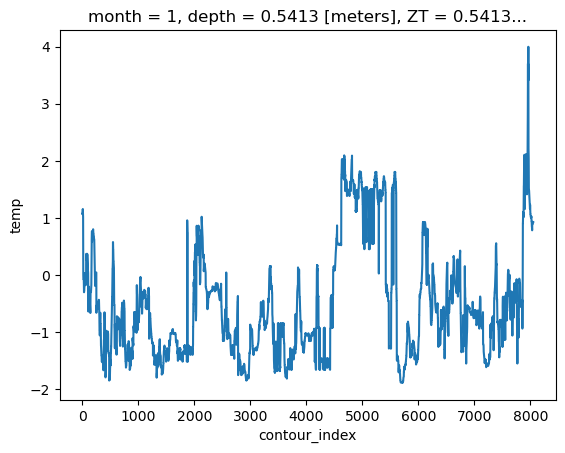

In [257]:
Kaihe_SST_alon_coast = Kaihe_OM2grid.temp.isel(ZT=0).sel(GRID_X_T = lon_along_contour, GRID_Y_T = lat_along_contour, method = 'nearest')
Kaihe_SST_alon_coast = Kaihe_SST_alon_coast.interpolate_na(dim='contour_index',method = 'nearest').bfill('contour_index').ffill('contour_index')
Kaihe_SST_alon_coast.plot()

In [258]:
%%time
lat_slice_interp = slice(-79,-63)
lat_distance_ratio_blowup = 4.5 # this a latitude streching approach that is used with the aim of making sure latitudinal propagaion is minimal
x = np.array(lon_along_contour).astype('float32')
y = np.array(lat_along_contour).astype('float32') * lat_distance_ratio_blowup
z = np.array(Kaihe_SST_alon_coast).astype('float32')

xi = np.array(Kaihe_OM2grid_CT.GRID_X_T).astype('float32')
yi = np.array(Kaihe_OM2grid_CT.GRID_Y_T.sel(GRID_Y_T=lat_slice_interp)).astype('float32') * lat_distance_ratio_blowup
xi, yi = np.meshgrid(xi, yi)
xi, yi = xi.flatten(), yi.flatten()

grid3 = linear_rbf(x,y,z,xi,yi)

nx = np.array(Kaihe_OM2grid_CT.GRID_X_T).shape[0]
ny = np.array(Kaihe_OM2grid_CT.GRID_Y_T.sel(GRID_Y_T=lat_slice_interp)).shape[0]
grid3 = grid3.reshape((ny, nx))

CPU times: user 2min 36s, sys: 1min 4s, total: 3min 40s
Wall time: 2min 22s


In [259]:
#creating the xarray with the same dimensions as the original IC
Kaihe_IDW = Kaihe_OM2grid_CT.sel(GRID_Y_T=lat_slice_interp)
Kaihe_IDW.values =  grid3

Kaihe_IDW_expanded = Kaihe_IDW.interp(GRID_Y_T = Pauthenet_OM2grid_CT.GRID_Y_T).bfill('GRID_Y_T')
Kaihe_IDW_expanded_appeneded = Kaihe_OM2grid_CT.fillna(-99999).ffill('GRID_Y_T')
Kaihe_IDW_expanded_appeneded = Kaihe_IDW_expanded_appeneded.where(Kaihe_IDW_expanded_appeneded>=-9999,Kaihe_IDW_expanded)

#### Comparisson plot with IDW

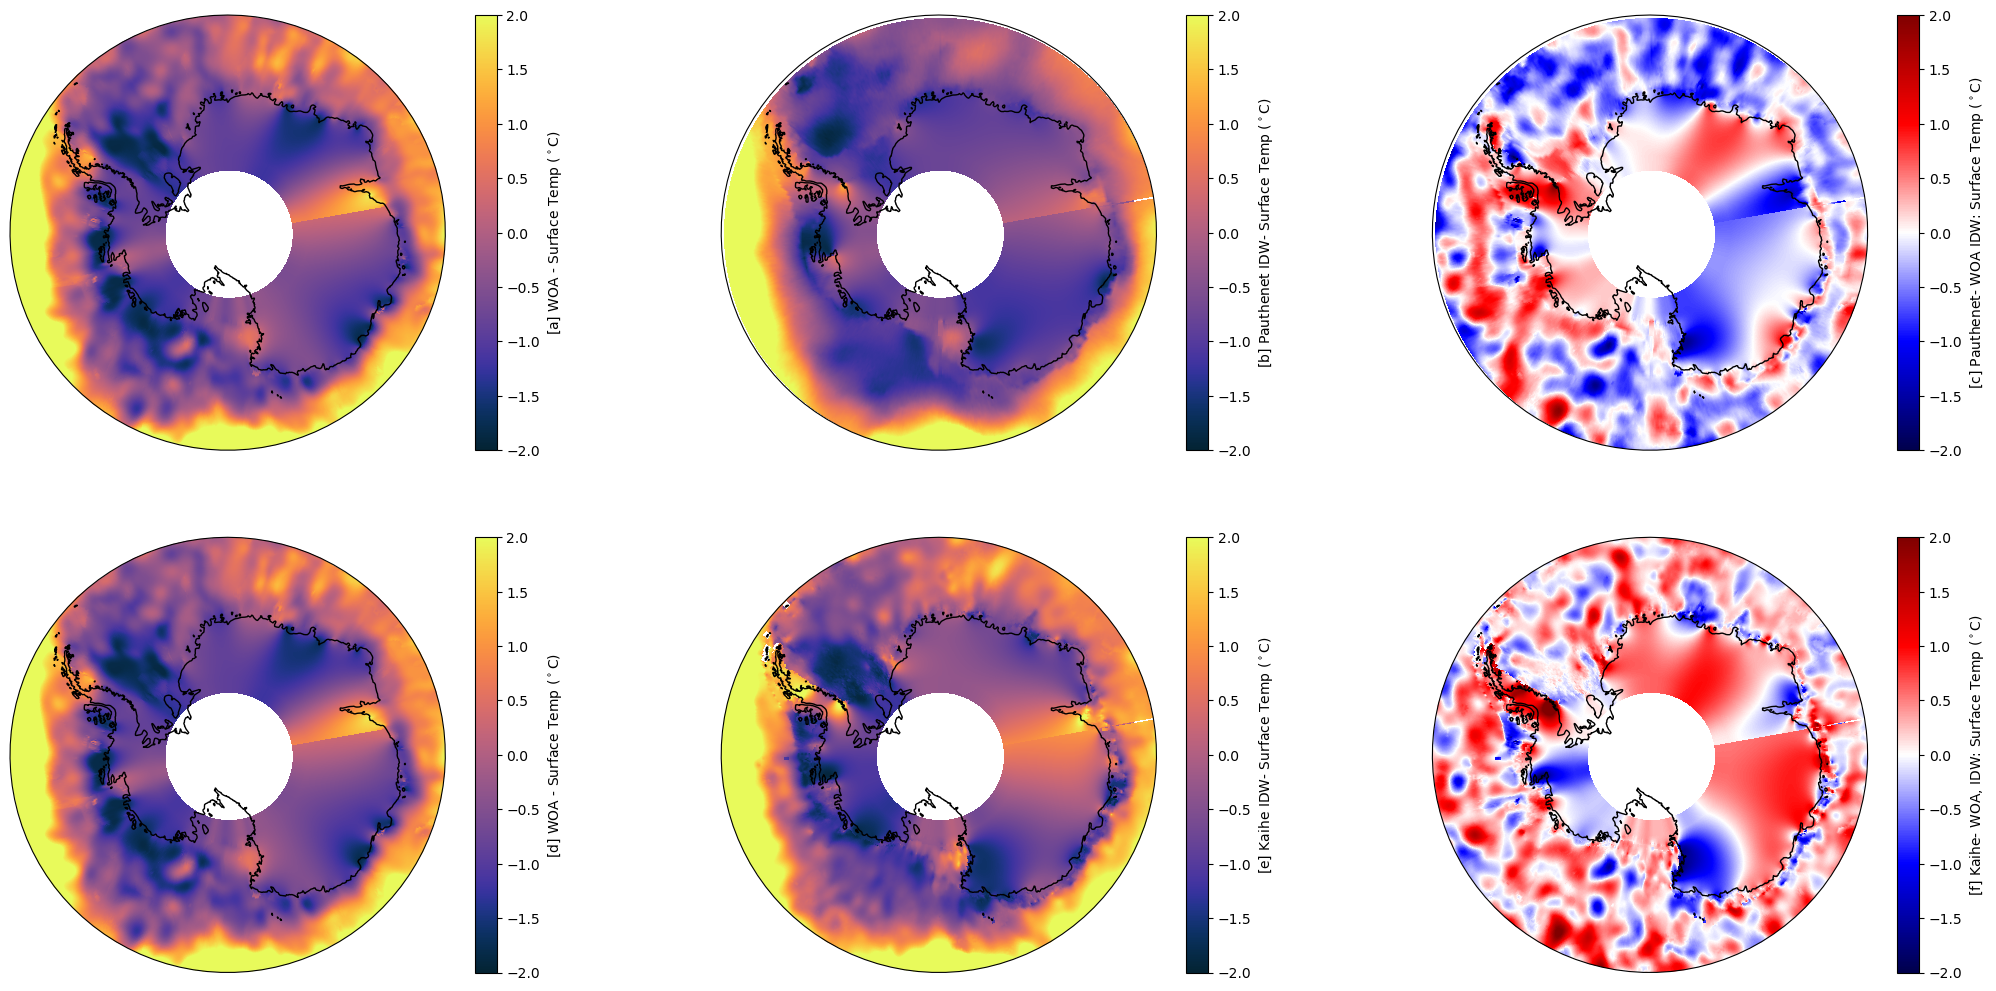

In [260]:
projection = ccrs.SouthPolarStereo()

fig = plt.figure(figsize=(26,26))
ax = fig.add_subplot(4,3,1,projection=projection)

ax.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree()) # plotting from COSIMA recipes cartopy tutorial
ax.coastlines(resolution="50m")



theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)


plt.pcolormesh(WOA.GRID_X_T,
               WOA.GRID_Y_T,
               WOA_IDW_expanded_appeneded,
               transform=ccrs.PlateCarree(), vmin = -2, vmax = 2, cmap = cmo.thermal)
plt.colorbar(label = '[a] WOA - Surface Temp ($^\circ$C)')



ax222 = fig.add_subplot(4,3,2,projection=projection)
ax222.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree()) # plotting from COSIMA recipes cartopy tutorial
ax222.coastlines(resolution="50m")



theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax222.set_boundary(circle, transform=ax222.transAxes)


plt.pcolormesh(Pauthenet_OM2grid_CT.GRID_X_T,
               Pauthenet_OM2grid_CT.GRID_Y_T,
               Pauthenet_IDW_expanded_appeneded.T,
               transform=ccrs.PlateCarree(), vmin = -2, vmax = 2, cmap = cmo.thermal)
plt.colorbar(label = '[b] Pauthenet IDW- Surface Temp ($^\circ$C)')



ax223 = fig.add_subplot(4,3,3,projection=projection)
ax223.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree()) # plotting from COSIMA recipes cartopy tutorial
ax223.coastlines(resolution="50m")




theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax223.set_boundary(circle, transform=ax223.transAxes)


plt.pcolormesh(Pauthenet_OM2grid_CT.GRID_X_T,
               Pauthenet_OM2grid_CT.GRID_Y_T,
               (Pauthenet_IDW_expanded_appeneded - WOA_IDW_expanded_appeneded).T,
               transform=ccrs.PlateCarree(), vmin = -2, vmax = 2, cmap = 'seismic')
plt.colorbar(label = '[c] Pauthenet- WOA IDW: Surface Temp ($^\circ$C)')




axl221= fig.add_subplot(4,3,4,projection=projection)

axl221.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree()) # plotting from COSIMA recipes cartopy tutorial
axl221.coastlines(resolution="50m")



theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
axl221.set_boundary(circle, transform=axl221.transAxes)


plt.pcolormesh(WOA.GRID_X_T,
               WOA.GRID_Y_T,
               WOA_IDW_expanded_appeneded,
               transform=ccrs.PlateCarree(), vmin = -2, vmax = 2, cmap = cmo.thermal)
plt.colorbar(label = '[d] WOA - Surface Temp ($^\circ$C)')



axl222= fig.add_subplot(4,3,5,projection=projection)
axl222.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree()) # plotting from COSIMA recipes cartopy tutorial
axl222.coastlines(resolution="50m")



theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
axl222.set_boundary(circle, transform=axl222.transAxes)


plt.pcolormesh(Kaihe_OM2grid.GRID_X_T,
               Kaihe_OM2grid.GRID_Y_T,
               Kaihe_IDW_expanded_appeneded,
               transform=ccrs.PlateCarree(), vmin = -2, vmax = 2, cmap = cmo.thermal)
plt.colorbar(label = '[e] Kaihe IDW- Surface Temp ($^\circ$C)')




axl223= fig.add_subplot(4,3,6,projection=projection)

axl223.set_extent([-280, 80, -80, -60], crs=ccrs.PlateCarree()) # plotting from COSIMA recipes cartopy tutorial
axl223.coastlines(resolution="50m")



theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
axl223.set_boundary(circle, transform=axl223.transAxes)

plt.pcolormesh(Kaihe_OM2grid.GRID_X_T,
               Kaihe_OM2grid.GRID_Y_T,
               (Kaihe_IDW_expanded_appeneded  - WOA_IDW_expanded_appeneded),
               transform=ccrs.PlateCarree(), vmin = -2, vmax = 2, cmap = 'seismic')
plt.colorbar(label = '[f] Kaihe- WOA, IDW: Surface Temp ($^\circ$C)')

# STOPPED HERE

__________________

Let's also evaluate how these plots look like when we integrate in a depth range of 100 meters?

In [71]:
#getting dzt for averaging
session = cc.database.create_session()
dzt = cc.querying.getvar('01deg_jra55v13_ryf9091','dzt',session,n=1).sel(yt_ocean = lat_slice).isel(time = 0).load()
WOA_dzt = WOA.temp.isel(time=0).copy()
WOA_dzt.values = dzt
WOA_dzt = WOA_dzt.bfill('GRID_Y_T')

In [77]:
depth_treshold = 500
depth_slice = slice(0,depth_treshold)

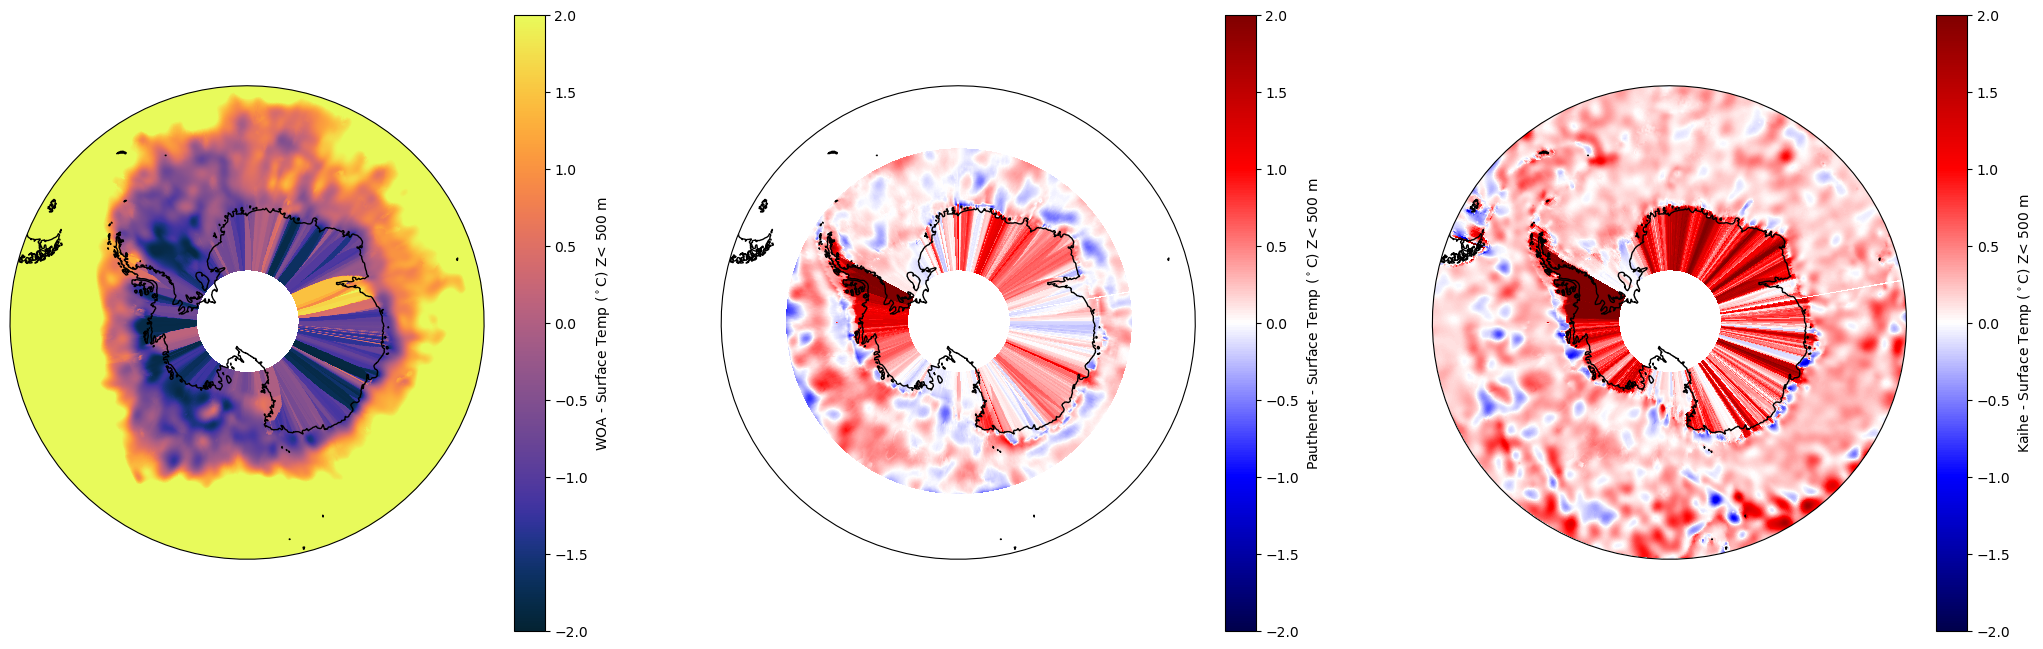

In [78]:
projection = ccrs.SouthPolarStereo()

fig = plt.figure(figsize=(26,8))
ax = fig.add_subplot(1,3,1,projection=projection)

ax.set_extent([-280, 80, -80, -50], crs=ccrs.PlateCarree()) # plotting from COSIMA recipes cartopy tutorial
ax.coastlines(resolution="50m")



theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)


plt.pcolormesh(WOA.GRID_X_T,
               WOA.GRID_Y_T,
               WOA.temp.isel(ZT=0,time = 0),
               transform=ccrs.PlateCarree(), vmin = -2, vmax = 2, cmap = cmo.thermal)
plt.colorbar(label = 'WOA - Surface Temp ($^\circ$C) Z< ' +  str(depth_treshold) + ' m')



ax222 = fig.add_subplot(1,3,2,projection=projection)
ax222.set_extent([-280, 80, -80, -50], crs=ccrs.PlateCarree()) # plotting from COSIMA recipes cartopy tutorial
ax222.coastlines(resolution="50m")



theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax222.set_boundary(circle, transform=ax222.transAxes)


plt.pcolormesh(Pauthenet_OM2grid_CT.GRID_X_T,
               Pauthenet_OM2grid_CT.GRID_Y_T,
               (Pauthenet_OM2grid_CT.T - WOA.temp.isel(time = 0)).sel(ZT = depth_slice)\
               .weighted(WOA_dzt.fillna(0)).mean('ZT'),
               transform=ccrs.PlateCarree(), vmin = -2, vmax = 2, cmap = 'seismic')
plt.colorbar(label = 'Pauthenet - Surface Temp ($^\circ$C) Z< ' +  str(depth_treshold) + ' m')



ax223 = fig.add_subplot(1,3,3,projection=projection)
ax223.set_extent([-280, 80, -80, -50], crs=ccrs.PlateCarree()) # plotting from COSIMA recipes cartopy tutorial
ax223.coastlines(resolution="50m")



theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax223.set_boundary(circle, transform=ax223.transAxes)


plt.pcolormesh(Kaihe_OM2grid.GRID_X_T,
               Kaihe_OM2grid.GRID_Y_T,
               (Kaihe_OM2grid.temp - WOA.temp.isel(time = 0)).sel(ZT = depth_slice)\
               .weighted(WOA_dzt.fillna(0)).mean('ZT'),
               transform=ccrs.PlateCarree(), vmin = -2, vmax = 2, cmap = 'seismic')
plt.colorbar(label = 'Kaihe - Surface Temp ($^\circ$C) Z< ' +  str(depth_treshold) + ' m')

